In [51]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
%matplotlib inline
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [52]:
taxi_data = pd.read_csv("../clean_data/TaxiData_Jan17-Jun17.gz", compression="gzip")

In [53]:
taxi_data.shape

(1471188, 7)

In [54]:
taxi_data.head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2017-01-01 00:00:05   2017-01-01 00:15:36                1           8.47   
1  2017-01-01 00:00:12   2017-01-01 00:09:48                1           5.30   
2  2017-01-01 00:00:17   2017-01-01 00:19:40                2          13.97   
3  2017-01-01 00:00:21   2017-01-01 00:12:09                1           6.90   
4  2017-01-01 00:00:33   2017-01-01 00:31:58                2          10.50   

   PULocationID  DOLocationID  total_amount  
0           138           262         38.55  
1           138           192         17.30  
2           138           181         50.44  
3           138            80         21.30  
4           138           230         42.34

### Add year, month, day, hour columns

In [55]:
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
taxi_data['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data['tpep_dropoff_datetime'])
taxi_data['year'] = taxi_data['tpep_pickup_datetime'].dt.year
taxi_data['month'] = taxi_data['tpep_pickup_datetime'].dt.month
taxi_data['pickup_day'] = taxi_data['tpep_pickup_datetime'].dt.day
taxi_data['pickup_hour'] = taxi_data['tpep_pickup_datetime'].dt.hour
taxi_data['dropoff_day'] = taxi_data['tpep_dropoff_datetime'].dt.day
taxi_data['dropoff_hour'] = taxi_data['tpep_dropoff_datetime'].dt.hour

### Adding Holiday Column

In [56]:
dr = pd.to_datetime(pd.to_datetime(taxi_data['tpep_pickup_datetime']).dt.date)

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

taxi_data['holiday'] = dr.isin(holidays)

In [57]:
names = cal.holidays(return_name = True)
# data = pd.concat([taxi_data, names], axis=1, join_axes=[taxi_data.tpep_pickup_datetime])

In [58]:
taxi_data.head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2017-01-01 00:00:05   2017-01-01 00:15:36                1           8.47   
1  2017-01-01 00:00:12   2017-01-01 00:09:48                1           5.30   
2  2017-01-01 00:00:17   2017-01-01 00:19:40                2          13.97   
3  2017-01-01 00:00:21   2017-01-01 00:12:09                1           6.90   
4  2017-01-01 00:00:33   2017-01-01 00:31:58                2          10.50   

   PULocationID  DOLocationID  total_amount  year  month  pickup_day  \
0           138           262         38.55  2017      1           1   
1           138           192         17.30  2017      1           1   
2           138           181         50.44  2017      1           1   
3           138            80         21.30  2017      1           1   
4           138           230         42.34  2017      1           1   

   pickup_hour  dropoff_day  dropoff_hour holiday  
0            0            1             0   False  
1            0            1             0   False  
2            0            1             0   False  
3            0            1             0   False  
4            0            1             0   False

## Exploratory Data Analysis

### How many trips on Holiday vs Non-Holiday days

In [59]:
taxi_data.holiday.value_counts(), taxi_data.holiday.value_counts(normalize=True)

(False    1434215
 True       36973
 Name: holiday, dtype: int64, False    0.974869
 True     0.025131
 Name: holiday, dtype: float64)

97% of the pickups belong to non-Holiday days while 3% during Holiday dates.

### Avg Trip Duration H vs NH

In [60]:
taxi_data.groupby('holiday', as_index=False)['trip_distance'].mean()

holiday  trip_distance
0   False       9.846936
1    True       9.762613

In [61]:
type(taxi_data.tpep_pickup_datetime)

pandas.core.series.Series

In [62]:
pickup = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
dropoff = pd.to_datetime(taxi_data['tpep_dropoff_datetime'])
taxi_data['trip_duration'] = dropoff-pickup
taxi_data['trip_duration'] = taxi_data['trip_duration'].dt.total_seconds()

In [63]:
taxi_data.head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2017-01-01 00:00:05   2017-01-01 00:15:36                1           8.47   
1  2017-01-01 00:00:12   2017-01-01 00:09:48                1           5.30   
2  2017-01-01 00:00:17   2017-01-01 00:19:40                2          13.97   
3  2017-01-01 00:00:21   2017-01-01 00:12:09                1           6.90   
4  2017-01-01 00:00:33   2017-01-01 00:31:58                2          10.50   

   PULocationID  DOLocationID  total_amount  year  month  pickup_day  \
0           138           262         38.55  2017      1           1   
1           138           192         17.30  2017      1           1   
2           138           181         50.44  2017      1           1   
3           138            80         21.30  2017      1           1   
4           138           230         42.34  2017      1           1   

   pickup_hour  dropoff_day  dropoff_hour holiday  trip_duration  
0            0            1             0   False          931.0  
1            0            1             0   False          576.0  
2            0            1             0   False         1163.0  
3            0            1             0   False          708.0  
4            0            1             0   False         1885.0

In [68]:
def calculate_avg_taxis_per_hour(df):
    count_per_hour = df['pickup_hour'].value_counts().sort_index()
    number_of_days = (df['tpep_pickup_datetime'].max() - df['tpep_pickup_datetime'].min()).days
    average_per_hour = count_per_hour / number_of_days
    
    # Plot average number of arrivals at LGA per hour per day
    ax = average_per_hour.plot(kind='bar', title='Average Number of Arriving Flights per Hour per Day at LaGuardia', figsize=(16,8))
    ax.set_ylabel("Average Number of Arrivals")
    ax.set_xlabel("Hour")
    
    return average_per_hour

0     243.288889
1      71.133333
2      18.138889
3       4.183333
4       4.916667
5       9.277778
6      22.905556
7     172.277778
8     295.894444
9     405.316667
10    492.083333
11    476.672222
12    449.400000
13    439.622222
14    474.183333
15    488.755556
16    512.038889
17    537.338889
18    527.844444
19    520.122222
20    490.705556
21    528.588889
22    514.505556
23    474.072222
Name: pickup_hour, dtype: float64

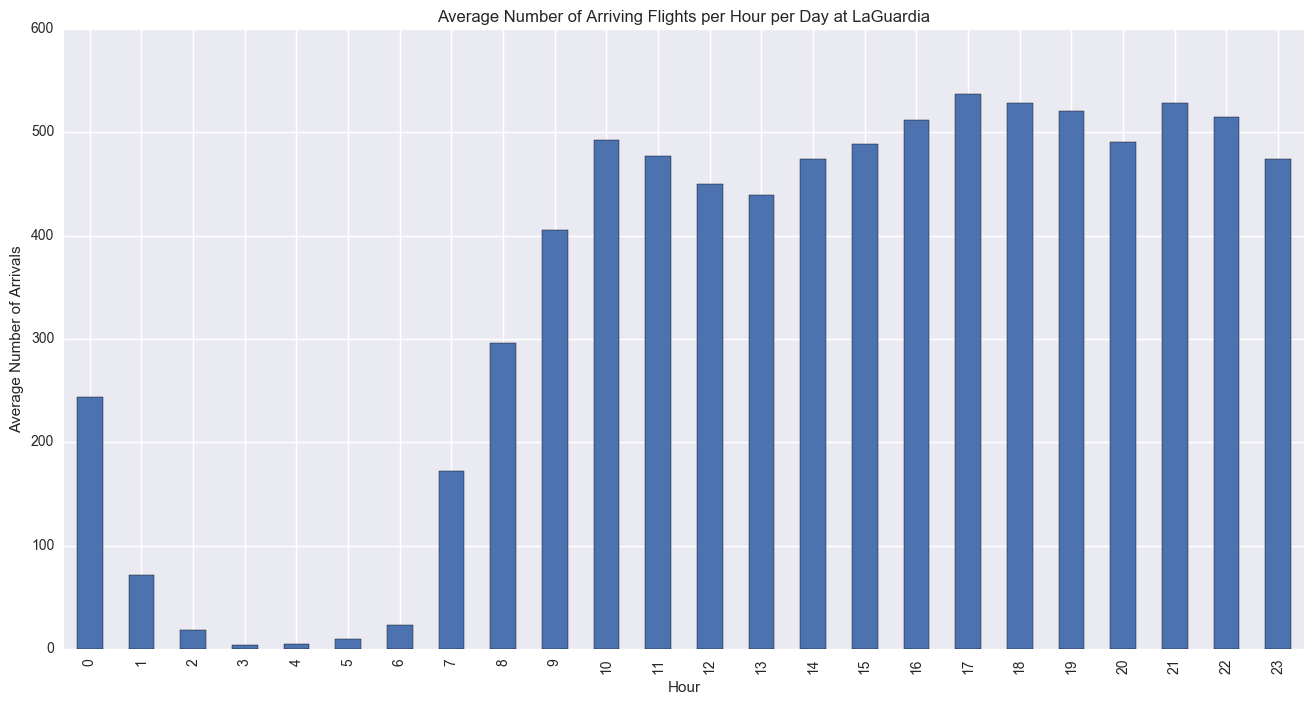

In [69]:
calculate_avg_taxis_per_hour(taxi_data)

In [164]:
def calculate_avg_taxis_per_hour_hol(df):
    count_per_hour = df.groupby('holiday')['pickup_hour'].value_counts().sort_index()
    number_of_days = (df['tpep_pickup_datetime'].max() - df['tpep_pickup_datetime'].min()).days
    average_per_hour = count_per_hour / number_of_days
    new_df = pd.DataFrame({'holiday':average_per_hour.index, 'list':average_per_hour.values}) 
    sns.barplot(x="holiday", y="list", data=new_df)
    return new_df

holiday        list
0    (False, 0)  239.511111
1    (False, 1)   70.900000
2    (False, 2)   18.133333
3    (False, 3)    4.172222
4    (False, 4)    4.777778
5    (False, 5)    9.122222
6    (False, 6)   22.588889
7    (False, 7)  169.377778
8    (False, 8)  289.744444
9    (False, 9)  396.816667
10  (False, 10)  481.733333
11  (False, 11)  466.611111
12  (False, 12)  439.088889
13  (False, 13)  428.911111
14  (False, 14)  462.838889
15  (False, 15)  476.694444
16  (False, 16)  499.194444
17  (False, 17)  523.994444
18  (False, 18)  512.933333
19  (False, 19)  505.016667
20  (False, 20)  476.922222
21  (False, 21)  512.533333
22  (False, 22)  497.400000
23  (False, 23)  458.844444
24    (True, 0)    3.777778
25    (True, 1)    0.233333
26    (True, 2)    0.005556
27    (True, 3)    0.011111
28    (True, 4)    0.138889
29    (True, 5)    0.155556
30    (True, 6)    0.316667
31    (True, 7)    2.900000
32    (True, 8)    6.150000
33    (True, 9)    8.500000
34   (True, 10)   10.350000
35   (True, 11)   10.061111
36   (True, 12)   10.311111
37   (True, 13)   10.711111
38   (True, 14)   11.344444
39   (True, 15)   12.061111
40   (True, 16)   12.844444
41   (True, 17)   13.344444
42   (True, 18)   14.911111
43   (True, 19)   15.105556
44   (True, 20)   13.783333
45   (True, 21)   16.055556
46   (True, 22)   17.105556
47   (True, 23)   15.227778

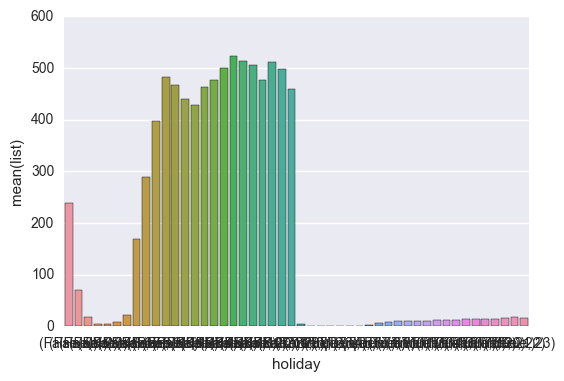

In [165]:
calculate_avg_taxis_per_hour_hol(taxi_data)